In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
import numpy as np

In [22]:
batch_size = 100
original_dim = 28*28 
latent_dim = 2
intermediate_dim = 256
num_epoch = 50
epsilon_std = 1.0

In [23]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0)
    return z_mean + K.exp(z_log_var / 2)*epsilon

In [24]:
x = Input(shape=(original_dim,), name='input')
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)
z_log_var = Dense(latent_dim, name='log_varience')(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name='encoder')

In [25]:
input_decoder = Input(shape=(latent_dim,), name='decoder_input')
h_decoder = Dense(intermediate_dim, activation='relu', name='decoder_h')(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name='flat_decoded')(h_decoder)
decoder = Model(input_decoder, x_decoded, name='decoder')

In [26]:
combined_output = decoder(encoder(x)[2])
vae = Model(x, combined_output)
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [27]:
def vae_loss(x: tf.Tensor,  x_decoded_mean: tf.Tensor, 
             z_log_var=z_log_var, z_mean=z_mean, 
             original_dim=original_dim):
    x_ent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    # Measures diffrence between distributions
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    kae_loss = K.mean(x_ent_loss + kl_loss)
    
    return kae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [28]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [29]:
vae.fit(x_train, x_train,
       shuffle=True,
       epochs=num_epoch,
       validation_data=(x_test, x_test),
       batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 206us/step - loss: 191.2288 - val_loss: 172.1088
Epoch 2/50
60000/60000 [==============================] - 11s 191us/step - loss: 170.5905 - val_loss: 168.4330
Epoch 3/50
60000/60000 [==============================] - 11s 191us/step - loss: 166.9430 - val_loss: 165.1337
Epoch 4/50
60000/60000 [==============================] - 12s 194us/step - loss: 164.5236 - val_loss: 163.5097
Epoch 5/50
60000/60000 [==============================] - 11s 192us/step - loss: 162.7421 - val_loss: 162.2390
Epoch 6/50
60000/60000 [==============================] - 11s 191us/step - loss: 161.3245 - val_loss: 160.8707
Epoch 7/50
60000/60000 [==============================] - 12s 206us/step - loss: 160.1211 - val_loss: 159.6551
Epoch 8/50
60000/60000 [==============================] - 13s 209us/step - loss: 159.0715 - val_loss: 158.8066
Epoch 9/50
60000/60000 [==============================] - 12s 

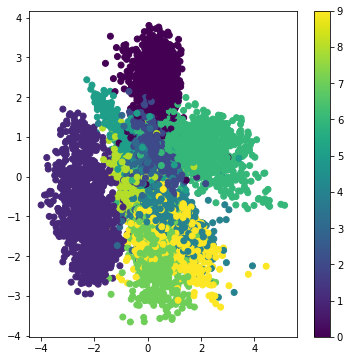

In [30]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

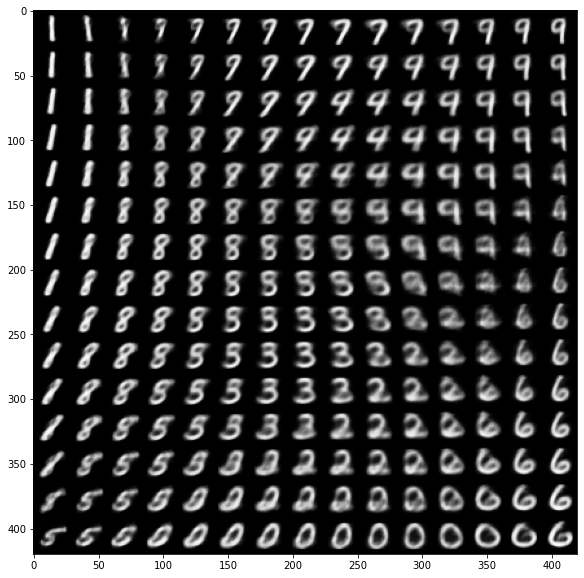

In [31]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
